## Generation of a simulated dataset of LSBGs using a Sérsic profile

In this notebook we create a dataset of simulated galaxies to be used for training (and evaluating) a Bayesian Neural Network (BNN), able to predict galaxy parameters.

We generate the galaxy images using `pyImfit` 

The details described below can be found in "IMFIT: A fast, flexible new program for astronomical image fitting"


### **Geometric parameters**

There are two geometric parameters in the image: the position angle, PA, in degrees (counterclockwise from the vertical axis of the image), and the ellipticity $\epsilon=1-b/a$, where $a$ and $b$ are the semimajor and semiminor axes, respectively.

We also define the axis ratio $q=b/a$ and the angle $\theta = PA + 90^\circ$.

Then for each input pixel with image coordinates ($x,y$) a scaled radius is computed as $ r = \left(x_p^2 + \frac{y_p^2}{q^2} \right)^{1/2}$,

where $x_p$ and $y_p$ are coordinates in the reference frame centered on the image function center ($x_0,y_0$) and rotated to its position angle:

\begin{equation}
x_p = (x-x_0)\cos \theta + (y-y_0) \sin \theta \\
y_p = - (x-x_0) \sin\theta + (y-y_0) \cos\theta
\end{equation}


### **Flat Sky Background**

We introduce a uniform sky background $I(x,y) = I_{sky}$ everywhere (all pixels).

### **Sérsic model**

\begin{equation}
\boxed{
I(r) = I_e \exp \left\{-b_n\left[\left(\frac{r}{r_e}\right)^{1/n} - 1 \right]\right\}}
\end{equation}


The parameters of the model are:

- $I_e$: Surface brightness at the effective (half-light) radius [counts/pixel].
 
- $r_e$: Effective radius [pixel].

- $n$: Sérsic index, controlling the shape of the intensity profile.


The valie of $b_n$ is formally given by the solution to the transcedental equation:


\begin{equation}
\Gamma (2n) = 2\gamma (2n, b_n)
\end{equation}

where $\Gamma(a)$ the Gamma function and $\gamma(a,x)$ incomplete gamma function.

In practice, some approximate polynomial functions are being used.

### **Converting pixel and count values to arcsec and mag/arcsec$^2$**

Instead of parametrizing the model parameters, such as the radius and the background and surface brightness at the effective radius, in pixels and counts/pixel we would like to generate images of simulated LSBGs in with these parameters in physical units (arcsec and mag/arcsec$^2$, respectively). 

To create DES-like LSBG models, we use the DES parameters for the conversion:

- DES plate scale: 1 pixel = $0.263''$.

- To convert counts/pixel to mag/arcsec^2  (or to find the value of flux in counts/pixel for a given surface brightness value) we use the following procedure:

The magnitude is defined as:

- \begin{equation}
m = - 2.5\log_{10}\left(\frac{counts}{pixel}\right) +zpm 
\end{equation}

where $zpm$ is the zero-point magnitude, which for DES is $zpm = 30$.

- The area of a pixel is $A = (0.263)^2$ arcsec$^2$.

The surface brightness is connected to the magnitude as:

\begin{equation}
S = m + 2.5log_{10}(A)
\end{equation}

Solving for counts per pixel, we have:
\begin{equation}
\boxed{
\frac{Counts}{pixel} = A\times 10^{(zpm-S)/2.5}}
\end{equation}

For the background $I_{sky}$ surface brightness in g-band we use the value $S=22.23$ mag/arcsec$^2$ provided by DES.

In [ ]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse

# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

In [ ]:
#!pip3 install pyimfit
import pyimfit

In [ ]:
# Mount drive to upload/download the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Function for surface brightness conversion**

Here we define a function that converts surface brightness, from physical units (mag/arcsec^2) to counts/pixel.

Here we assume the DES zero-point magnitude zpm=30 and plate scale 0.263''/pixel.

In [ ]:
def SB_conversion(SB_phys):
  """
  Convert surface brightness from
  mag/arcsec^2 to counts/pixel

  Input: 
  SB_brigth: surface brightness in mag/arcsec
  """
  plate_scale = 0.263 # Plate scale of DES
  zpm = 30.0 # DES zero-point magnitude

  A = plate_scale**2.0 #Area
  exponent = (zpm - SB_phys)/2.5
  counts = A*(10.**exponent)

  return counts

Data type of parameters

In [ ]:
SIZE = 64
DTYPE = [
    ('id',int),                # object id
    ('x',float),               # x-centroid
    ('y',float),               # y-centroid
    ('I_sky',float),           # background sky intensity (counts/pixel)
    ('PA',float),              # mean number of background photons
    ('ell',float),             # radius (pixels)
    ('n',float),               # ellipticity
    ('I_e',float),             # surface brightness at half-light radius
    ('r_e',float),             # half-light radius (pixels)
]

**Define function that creates population**

In [ ]:
def create_population(nsim=100, x=SIZE//2, y=SIZE//2, I_sky = 23,
                      PA=90., ell=0.5, n=1.0, I_e = 25., r_e = 3.):                 
    """ Create the population parameters
    Parameters
    ----------
    nsim : number of simulations
    x,y  : centroid location [pix]
    I_sky: background intensity [mag/arcsec^2]
    PA: position angle [deg]
    ell: ellipticity
    n: Sérsic index
    I_e: surface brightness at effective radius [mag/arcsec^2]
    r_e: effective radius [arcsec]
    """

    ones = np.array([1,1])
    x *= ones
    y *= ones
    I_sky *= ones
    PA *= ones
    ell *= ones
    n *= ones
    I_e *= ones
    r_e *= ones

    params = np.recarray(nsim,dtype=DTYPE)
    params['id']   = np.arange(nsim)
    params['x']    = np.random.uniform(x[0],x[1],nsim)
    params['y']    = np.random.uniform(y[0],y[1],nsim)
    params['I_sky'] = np.random.uniform(I_sky[0],I_sky[1],nsim)
    params['PA'] = np.random.uniform(PA[0],PA[1],nsim)    
    params['ell'] = np.random.uniform(ell[0],ell[1],nsim)
    params['n']  = np.random.uniform(n[0],n[1],nsim)
    params['I_e']  = np.random.uniform(I_e[0],I_e[1],nsim)
    params['r_e']  = np.random.uniform(r_e[0],r_e[1],nsim)


    return params

**Function that creates galaxy images**

In [ ]:
def create_galaxy(params):
  """ 
  Function that creates halaxy images given a set of parameters 
  (coordinates, background photons, PA, ell, n, I_e, r_e)
  """
  # Get relevant parameters 
  x_0 = params['x']
  y_0 = params['y']
  I_sky = params['I_sky']
  PA = params['PA']
  ell = params['ell']
  n = params['n']
  I_e = params['I_e']
  r_e = params['r_e']


  # ==========================================
  # Convert physical units to pixel and counts/pixel

  # Plate scale (arcsec/pixel)
  p_scale = 0.263 


  # Effective radius in pixels
  r_e_pix  = r_e/p_scale

  # Background sky surface brightess in counts/pixel
  I_sky_counts = SB_conversion(I_sky)
  # Galaxy surface brightness at effective radius in counts/pixel
  I_e_counts = SB_conversion(I_e)

  # ==========================================
  # ==========================================

  # Create model
  model = pyimfit.SimpleModelDescription()
  # define the X0,Y0 
  model.x0.setValue(x_0)
  model.y0.setValue(y_0)
  # create a FlatSky uniform background
  FlatSky_function = pyimfit.make_imfit_function("FlatSky")
  FlatSky_function.I_sky.setValue(I_sky_counts)
  # create a Sersic profile
  Sersic_function = pyimfit.make_imfit_function("Sersic")
  Sersic_function.PA.setValue(PA)
  Sersic_function.ell.setValue(ell)
  Sersic_function.n.setValue(n)
  Sersic_function.I_e.setValue(I_e_counts)
  Sersic_function.r_e.setValue(r_e_pix)

  # now add the Flatsky and Sersic profiles to the model function
  model.addFunction(FlatSky_function)
  model.addFunction(Sersic_function)



  imfitter = pyimfit.Imfit(model)
  img = imfitter.getModelImage(shape=(64,64))
  return sp.stats.poisson.rvs(img)

**Create catalog for training, validation, and testing**

Now we create a catalog of 

Paramater values and ranges:

- Position angle, PA $\in [0,180]$
- Background surface brightness, $I_{sky}$ = 22.23 mag/arcsec$^2$
- Ellipticity in the range $e \in [0.05,0.7]$.
- Sersic index in the range $n\in [0.5,1.5]$.
- Effective surface brightness $I_e \in [24.3-25.5]$ mag/arcsec$^2$.
- Effective radius in the range $r_e \in [2.5-6.0]$ arcsec.

These numbers have been selected to approximately reproduce the parameter range of the bulk of DES Y3 LSBGs (not outliers).

In [ ]:
# Define number of simulations here, 
# It will be used in the whole notebook
nsims = 170000

In [ ]:
catalog = create_population(nsim=nsims, PA=[0.,180.], I_sky=22.23, ell=[0.05,0.7],n=[0.5,1.5],I_e=[24.3,25.5],r_e=[2.5,6.0])


# Get labels - we will use them in the regression task
#I_sky_true = catalog['I_sky']
PA_true = catalog['PA']                   # Position angle
ell_true = catalog['ell']                 # ellipticity
n_true = catalog['n']                     # Sersic index
I_e_true = catalog['I_e']                 # surface brightness at effective radius [count/]
r_e_true = catalog['r_e']                 # effective radius [pix]

# ====================================================
# Concatenate the above parameters in a common y vector 
y_tot = np.column_stack((PA_true,ell_true,n_true,I_e_true,r_e_true))

In [ ]:
scaler = StandardScaler()

# Rescale the feature space
scaler.fit(y_tot)
y_scaled = scaler.transform(y_tot)

In [ ]:
images_training = []
for i,params in enumerate(catalog):
    img = create_galaxy(params)
    images_training.append(img)

### Plot a random subsample

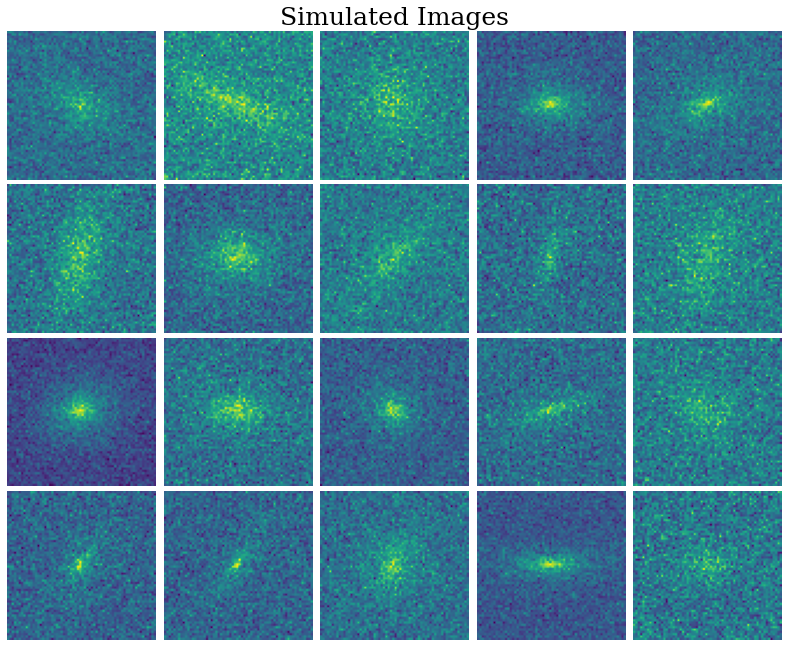

In [ ]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Simulated Images",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(images_training[i]/430.)
    plt.axis('off')


plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Simulated_Examples.pdf")
#files.download("/content/drive/My Drive/BNN_Final_Codes/Plots/Simulated_Examples.pdf")
plt.show()

In [ ]:
X_gals_scaled = np.zeros([nsims,64,64,1])
scaling = np.zeros(nsims)

for i in range(nsims):
  scaling[i] = np.max(images_training[i])
  input = images_training[i]/scaling[i]
  
  X_gals_scaled[i,:,:,0] = input

**Split into training, validation, and test sets**

In [ ]:
# Images
X_train = X_gals_scaled[0:150000]
X_val = X_gals_scaled[150000:160000]
X_test = X_gals_scaled[160000:]

# Labels 
y_train = y_tot[0:150000]
y_val = y_tot[150000:160000]
y_test = y_tot[160000:]

#scaling
scale_train = scaling[0:150000]
scale_val = scaling[150000:160000]
scale_test = scaling[160000:]

**Save training, validation, and test sets**

In [ ]:
# Images
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/X_train.npy",X_train)
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/X_val.npy",X_val)
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/X_test.npy",X_test)

# Labels
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_train.npy",y_train)
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_val.npy",y_val)
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_test.npy",y_test)

# Scaling
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/scale_train.npy",scale_train)
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/scale_val.npy",scale_val)
np.save("/content/drive/My Drive/BNN_Final_Codes/DataSets/scale_test.npy",scale_test)

### **Out-of-distribution datasets**

Here we create datasets with surface brightness lower than that of the training set.